In [1]:
%load_ext autoreload
%autoreload 2

In [65]:
import torch
from pathlib import Path

from PyLorentz.io import read_image


import numpy as np
import skimage.io as skio
import matplotlib.pyplot as plt
import scipy.ndimage as ndi

from PyLorentz.visualize import show_im, show_2D
from PyLorentz.phase.DIP_NN import DIP_NN
from PyLorentz.phase.AD_funcs import training_loop, sim_images_torch
from PyLorentz.phase.AD_utils import induction_from_phase, get_all_accs, get_TF  # put induction_from_phase in utils, is useful, can leave in base phase too
from PyLorentz.utils.microscopes import Microscope
from PyLorentz.utils.noise import ImageNoiser
from PyLorentz.sim import SimLTEM
from PyLorentz.phase.AD_phase import ADPhase
from PyLorentz.dataset import DefocusedDataset
import copy
from PyLorentz.phase import SITIE

print(f"There are {torch.cuda.device_count()} GPU(s) available")
device_ind = 0
print(f"Proceeding with GPU {device_ind}: {torch.cuda.get_device_name(device_ind)}")
device = torch.device(f'cuda:{device_ind}')

There are 1 GPU(s) available
Proceeding with GPU 0: NVIDIA RTX 2000 Ada Generation Laptop GPU


TODO 
1. update the image simulation part to be using SIMLTEM instead 
2. classes for SIPRAD recon 
3. demo of SIPRAD with amplitude
4. demo of SIPRAD with experimental data 

Text file found: d:\code\PyLorentz\Examples\data\CGT_sim_B0G.ovf
Simulation size (z, y, x) : (10, 512, 512)
Image (x-y) scale : 4 nm/pixel.
Out-of-plane (z) scale : 10 nm/pixel.


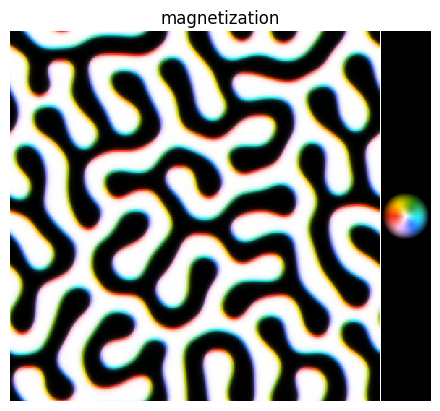

In [3]:
mag_f = Path("./data/CGT_sim_B0G.ovf")
simulator = SimLTEM.load_ovf(mag_f)
simulator.show_mags()

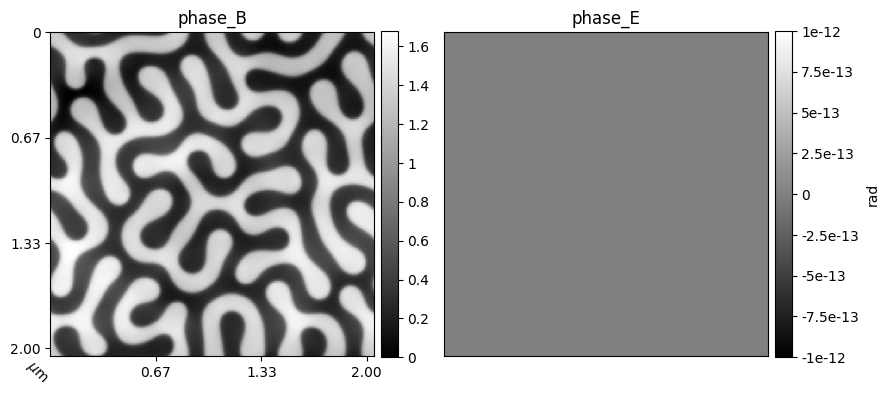

Simulating images for defocus values: -1 mm


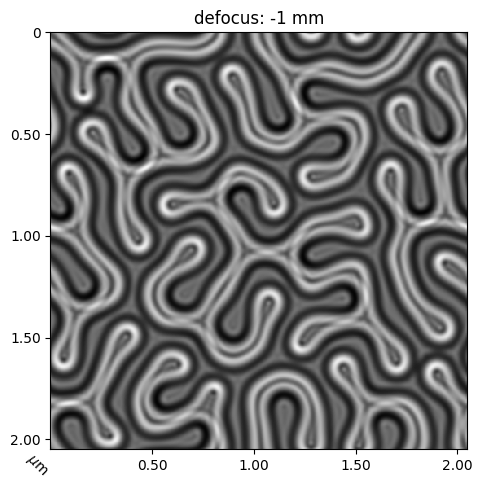

In [4]:
scope = Microscope(
    E=200e3,
    Cs=200e3,
    theta_c=0.01e-3,
    def_spr=80,
)

sample_params = {"B0" : 2.5e3}
simulator.set_sample_params(sample_params)
simulator.compute_phase(method="mans", beam_energy=scope.E)
simulator.show_phase()

defvals = [-1_000_000] # -1mm
dd = simulator.sim_images(defocus_values=defvals, scope=scope)

dd.show_im()

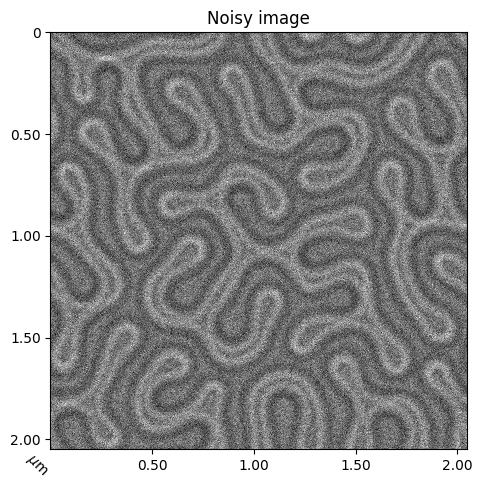

In [5]:
noiser = ImageNoiser(
    poisson = 1e7, # 1e7, total counts/intensity
    gauss = 50, # percent noise, 0+
    salt_and_pepper = 0, # 0+, ~10
    blur = 0, # sigma, 0+, ~0.5
    contrast = None, # 1-, 1+
    seed = 42,
)

noisy_im = noiser.run(dd.images)

noisy_dd = dd.copy()
noisy_dd.images = noisy_im
noisy_dd.show_im(title="Noisy image")


In [8]:


LRs = {
    "phase": 2e-4, # 2e-4 for DIP, 0.2 otherwise
    "amp": 2e-4, # 2e-4 for DIP, 0.02 otherwise
    "amp_scale": 0.01, # used when not solve_amp, 0.1 best
    "TV_phase_weight": 5e-3, # only used if reconstructing without DIPs
    "TV_amp_weight": 5e-3, # only used if reconstructing without DIPs
}

siprad = ADPhase(
    dd=noisy_dd,
    device=device,
    scope=scope,
    LRs=LRs,
    scheduler_type=None,
    noise_frac=1/30,
    guess_phase="SITIE",
    gaussian_sigma=1,
)

DIP_phase = DIP_NN()


Proceeding with GPU 0: NVIDIA RTX 2000 Ada Generation Laptop GPU


Pre-training


100%|██████████| 200/200 [00:04<00:00, 44.07it/s]


Reconstructing


100%|██████████| 300/300 [00:05<00:00, 59.76it/s]


total time (h:m:s) = 0:00:09


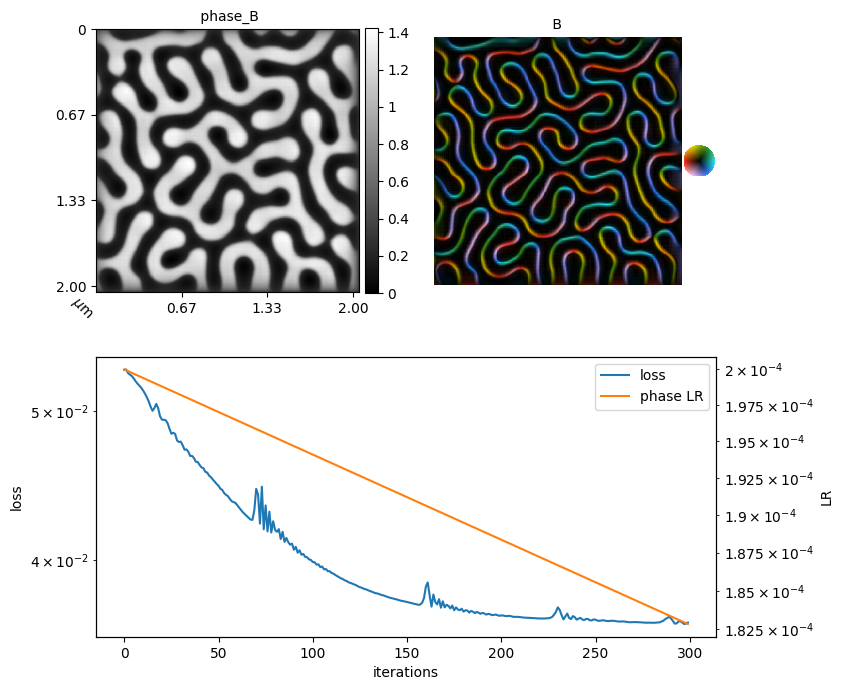

SIPRAD   phase: acc 94.6% SSIM 0.820 | Bave: acc 93.5% SSIM 0.885
SITIE    phase: acc 75.5% SSIM 0.654 | Bave: acc 87.2% SSIM 0.650


In [9]:
siprad.reconstruct(
    num_iter=300,
    model = DIP_phase,
    num_pretrain_iter=200,
    solve_amp=False,
    solve_amp_scale = True,
    guess_amp=None,
    reset=True, # will reset model weights
    print_every = -1,
    store_iters_every=100,
    verbose = 1, # verbose = 2 to show plots
    scheduler_type="exp",
)

siprad.visualize()

siprad_metrics = siprad.calc_phase_metrics(simulator.phase_B, siprad.best_phase)
sitie_metrics = siprad.calc_phase_metrics(simulator.phase_B, siprad.guess_phase)
print(f"{'SIPRAD':8} phase: acc {siprad_metrics['acc_phase']*100:.1f}% SSIM {siprad_metrics['SSIM_phase']:.3f} | Bave: acc {siprad_metrics['acc_Bave']*100:.1f}% SSIM {siprad_metrics['SSIM_Bave']:.3f}")
print(f"{'SITIE':8} phase: acc {sitie_metrics['acc_phase']*100:.1f}% SSIM {sitie_metrics['SSIM_phase']:.3f} | Bave: acc {sitie_metrics['acc_Bave']*100:.1f}% SSIM {sitie_metrics['SSIM_Bave']:.3f}")

TODO   
1. test simulated with amp variation, double DIP but more importantly a fixed guess_amp
3. test with experimental CGT data


### Demo with amplitude variation from contaminates 

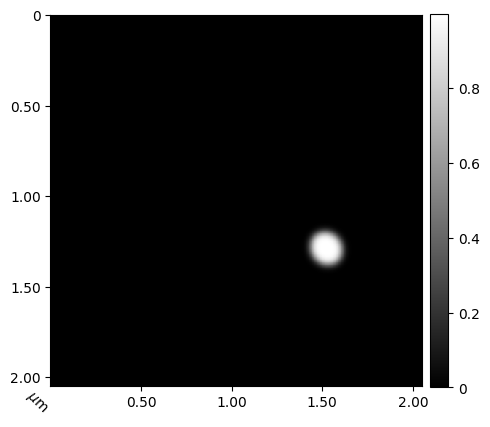

In [10]:
import skimage

num_dirt = 1
rand_shape = skimage.draw.random_shapes(noisy_im[0].shape, max_shapes=num_dirt, min_shapes=num_dirt,
                                             shape="ellipse", min_size=20, max_size=50, channel_axis=None, rng=42)[0]
dirt = np.where(rand_shape<255, 1, 0).astype('float')
dirt = ndi.gaussian_filter(dirt, 5)

show_im(dirt, scale=simulator.scale)

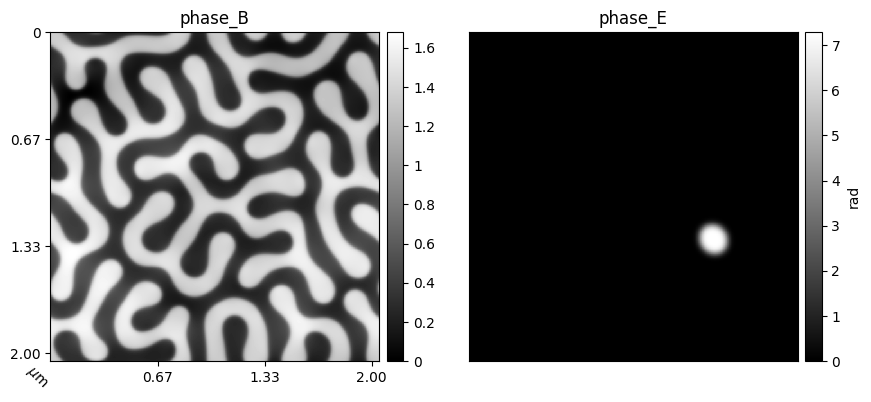

Simulating images for defocus values: -1 mm


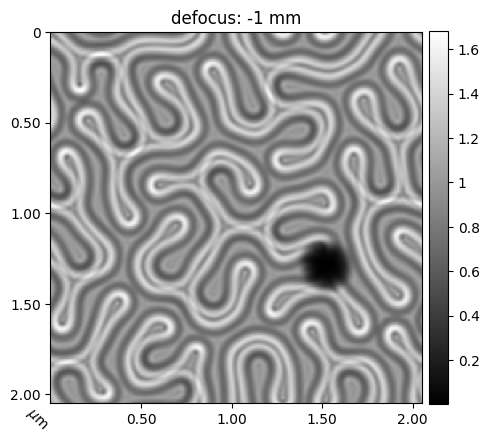

In [11]:
dirt_sim = simulator.copy()
shape_func = np.zeros(dirt_sim.shape).astype('float')
shape_func[5:] += dirt # 50 nm thick
dirt_sim.shape_func = shape_func

sample_params = {"B0" : 2.5e3, "sample_V0": 20, "sample_xip0": 10}

dirt_sim.set_sample_params(sample_params)
dirt_sim.compute_phase(method="mans", beam_energy=scope.E)
dirt_sim.show_phase()

defvals = [-1_000_000] # -1mm
dirty_dd = dirt_sim.sim_images(defocus_values=defvals, scope=scope)

dirty_dd.show_im(cbar=True)

In [110]:
np.mean(dirty_dd.image)

np.float64(0.9765049676467412)

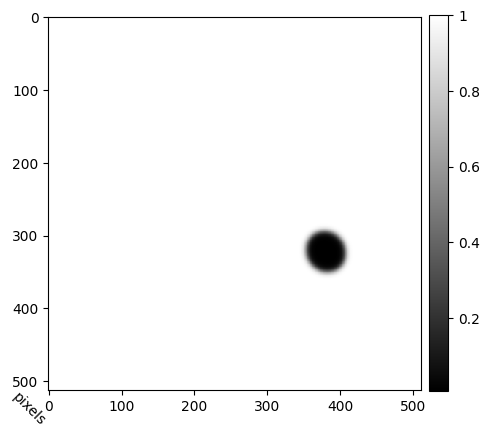

In [109]:
show_im(np.abs(dirt_sim._object_wave))

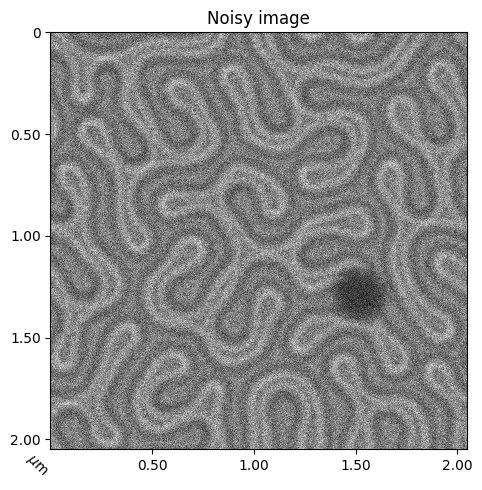

In [12]:
noiser = ImageNoiser(
    poisson = 1e7, # 1e7, total counts/intensity
    gauss = 50, # percent noise, 0+
    salt_and_pepper = 0, # 0+, ~10
    blur = 0, # sigma, 0+, ~0.5
    contrast = None, # 1-, 1+
    seed = 42,
)

noisy_dirt = noiser.run(dirty_dd.images)

dirty_dd.images = noisy_dirt
dirty_dd.show_im(title="Noisy image")


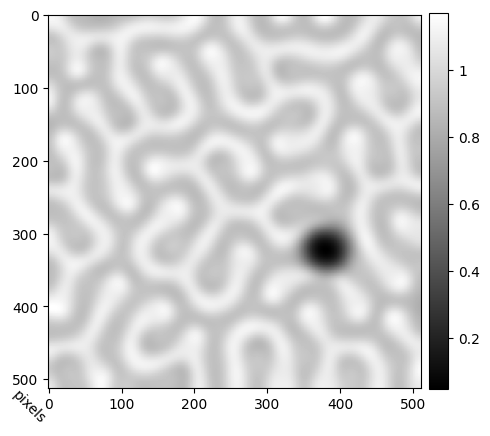

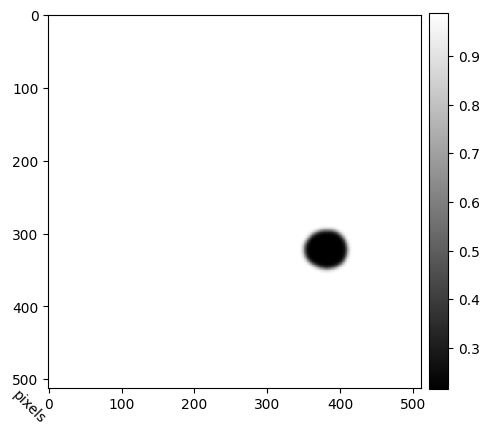

In [113]:
filt_im = ndi.gaussian_filter(dirty_dd.image, 10)
show_im(filt_im)
guess_amp = np.where(filt_im>0.5, np.sqrt(np.mean(filt_im)), np.sqrt(np.min(filt_im)))
guess_amp = ndi.gaussian_filter(guess_amp.astype('float'), 3)
show_im(guess_amp)

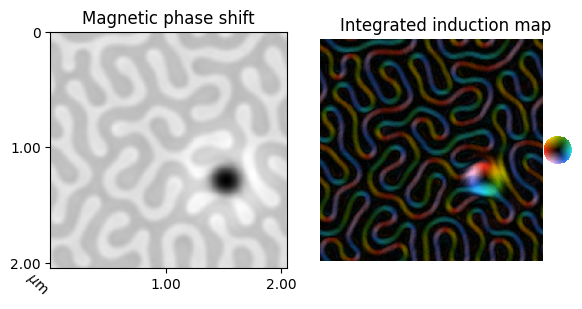

In [14]:
sitie = SITIE(dirty_dd)
qc = 0.001
sitie.reconstruct(qc=qc).visualize()

In [38]:
LRs = {
    "phase": 2e-4, # 2e-4 for DIP, 0.2 otherwise
    "amp": 2e-4, # 2e-4 for DIP, 0.02 otherwise
    "amp_scale": 0.1, # used when not solve_amp, 0.1 best
    "amp2phi_scale": 1,
    "TV_phase_weight": 0.1, #
    "TV_amp_weight": 0.1, #
}

# sample params can/should be approximated, they are used to calculate the scaling factor
# that converts amplitude -> phase_E, but this parameter will be learned.
# here we set them to a factor of 2 greater than the "true" values to demonstrate this
sample_params = {
    "dirt_V0" : 40,
    "dirt_xip0" : 20,
}


siprad_dirt = ADPhase(
    dd=dirty_dd,
    device=device,
    scope=scope,
    sample_params=sample_params,
    LRs=LRs,
    scheduler_type=None,
    noise_frac=1/100,
    guess_phase="SITIE",
    gaussian_sigma=1,
)

DIP_phase = DIP_NN()


Proceeding with GPU 0: NVIDIA RTX 2000 Ada Generation Laptop GPU


setting solve_amp and solve_amp_scale = False works if inputting a reasonably accurate guess_amp and correct sample params

SITIE guess phase:


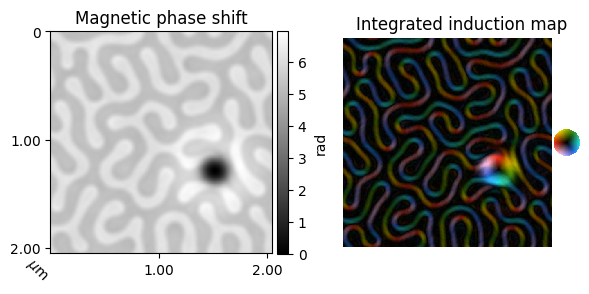

Pre-training


100%|██████████| 500/500 [00:07<00:00, 71.30it/s]


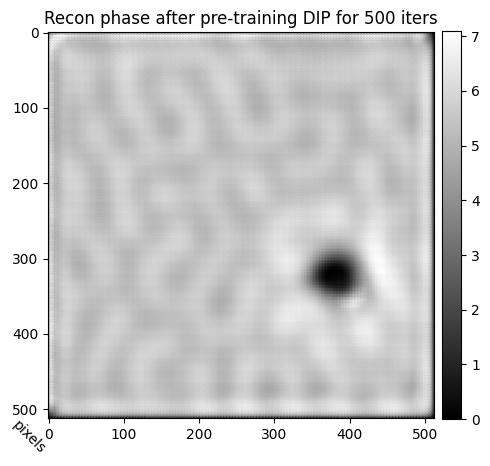

learning amp2phi as well
Reconstructing


100%|█████████▉| 997/1000 [00:37<00:00, 23.17it/s]

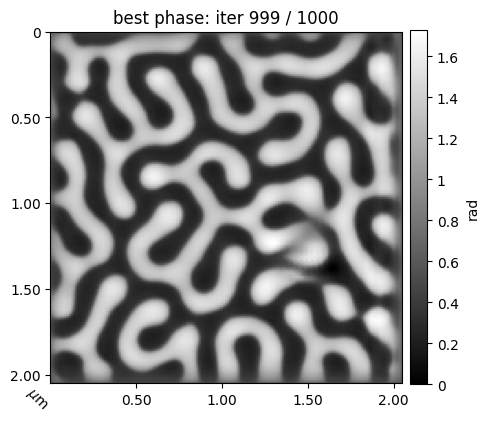

100%|██████████| 1000/1000 [00:37<00:00, 26.40it/s]


total time (h:m:s) = 0:00:45


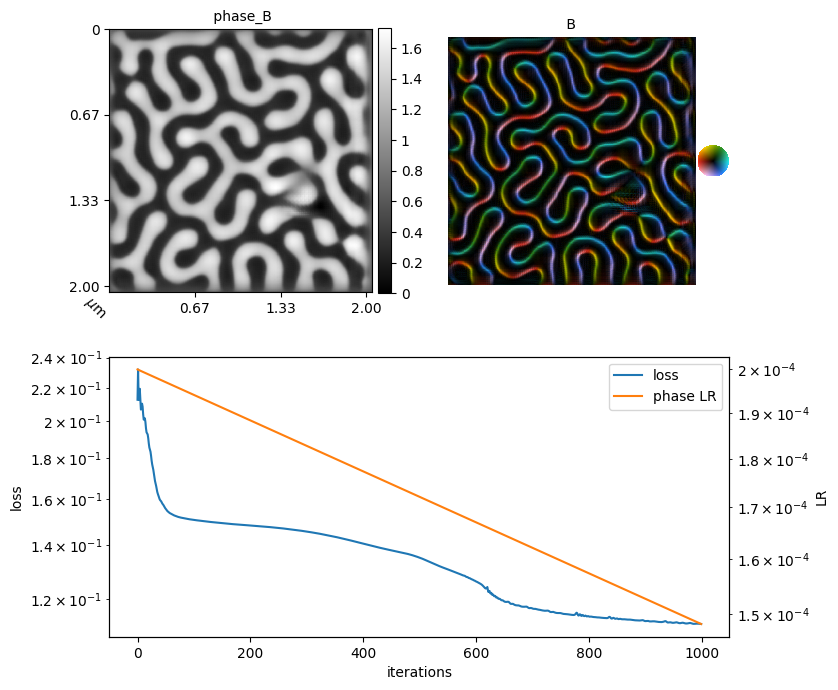

SIPRAD   phase: acc 91.9% SSIM 0.851 | Bave: acc 89.6% SSIM 0.823
SITIE    phase: acc 57.8% SSIM 0.231 | Bave: acc 76.4% SSIM 0.728


In [39]:
siprad_dirt.reconstruct(
    num_iter=1000,
    model = DIP_phase,
    num_pretrain_iter=500,
    solve_amp=False,
    solve_amp_scale = True,
    guess_amp=guess_amp,
    reset=True, # will reset model weights
    store_iters_every=1000,
    verbose = 2, # verbose = 2 to show plots
    scheduler_type="exp",
    qc=0.001,
)

siprad_dirt.visualize()

siprad_metrics = siprad_dirt.calc_phase_metrics(simulator.phase_B, siprad_dirt.best_phase)
sitie_metrics = siprad_dirt.calc_phase_metrics(simulator.phase_B, siprad_dirt.guess_phase)
print(f"{'SIPRAD':8} phase: acc {siprad_metrics['acc_phase']*100:.1f}% SSIM {siprad_metrics['SSIM_phase']:.3f} | Bave: acc {siprad_metrics['acc_Bave']*100:.1f}% SSIM {siprad_metrics['SSIM_Bave']:.3f}")
print(f"{'SITIE':8} phase: acc {sitie_metrics['acc_phase']*100:.1f}% SSIM {sitie_metrics['SSIM_phase']:.3f} | Bave: acc {sitie_metrics['acc_Bave']*100:.1f}% SSIM {sitie_metrics['SSIM_Bave']:.3f}")

Reconstructing


 50%|████▉     | 999/2000 [00:26<00:45, 22.06it/s]

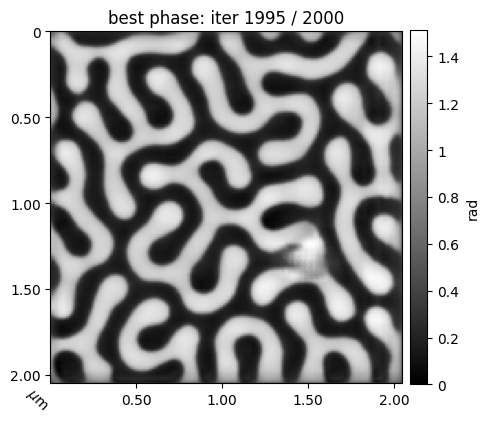

100%|█████████▉| 1998/2000 [01:00<00:00, 67.87it/s]

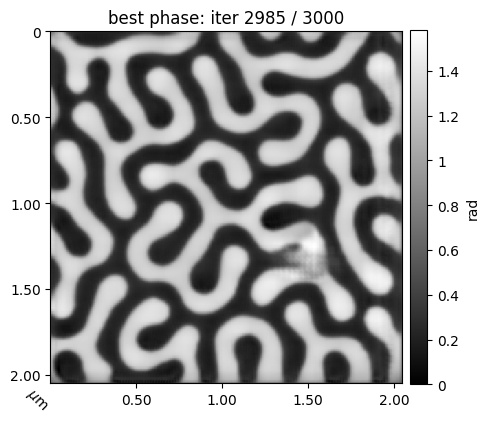

100%|██████████| 2000/2000 [01:01<00:00, 32.73it/s]


total time (h:m:s) = 0:01:01


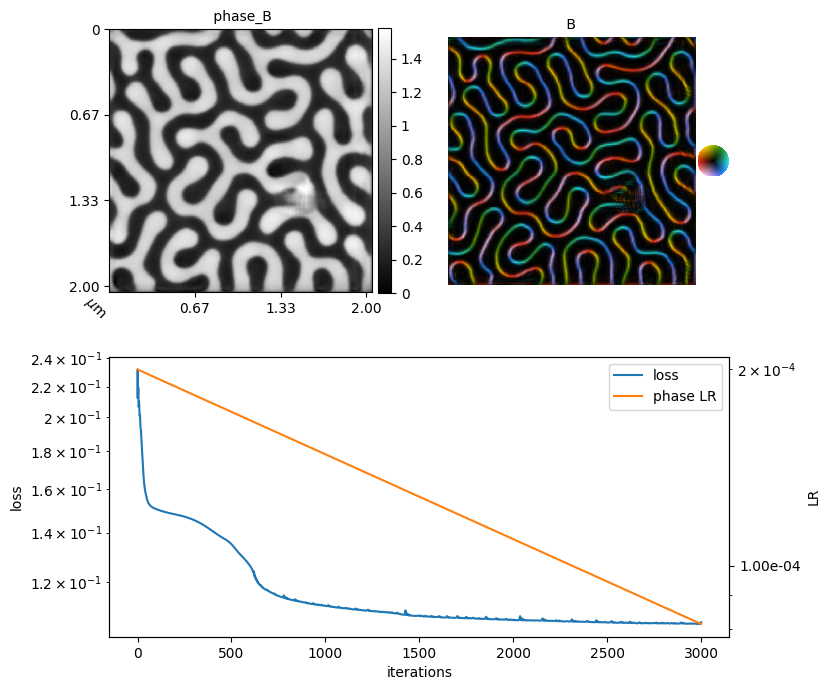

SIPRAD   phase: acc 96.6% SSIM 0.909 | Bave: acc 95.5% SSIM 0.900
SITIE    phase: acc 57.8% SSIM 0.231 | Bave: acc 76.4% SSIM 0.728


In [42]:
siprad_dirt.reconstruct(
    num_iter=2000,
    model = DIP_phase,
    num_pretrain_iter=500,
    solve_amp=False,
    solve_amp_scale = True,
    guess_amp=guess_amp,
    reset=False, # will reset model weights
    store_iters_every=1000,
    verbose = 2, # verbose = 2 to show plots
    scheduler_type="exp",
    qc=0.001,
)

siprad_dirt.visualize()

siprad_metrics = siprad_dirt.calc_phase_metrics(simulator.phase_B, siprad_dirt.best_phase)
sitie_metrics = siprad_dirt.calc_phase_metrics(simulator.phase_B, siprad_dirt.guess_phase)
print(f"{'SIPRAD':8} phase: acc {siprad_metrics['acc_phase']*100:.1f}% SSIM {siprad_metrics['SSIM_phase']:.3f} | Bave: acc {siprad_metrics['acc_Bave']*100:.1f}% SSIM {siprad_metrics['SSIM_Bave']:.3f}")
print(f"{'SITIE':8} phase: acc {sitie_metrics['acc_phase']*100:.1f}% SSIM {sitie_metrics['SSIM_phase']:.3f} | Bave: acc {sitie_metrics['acc_Bave']*100:.1f}% SSIM {sitie_metrics['SSIM_Bave']:.3f}")

### experimental data

In [94]:
704/8

88.0

Filtering hot/dead pixels


100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


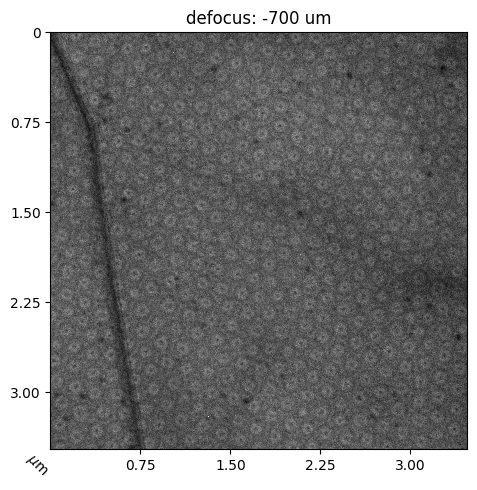

Rotation:    0 | Points: (1000,  500), (1704, 1204) | Dimensions (h x w):  704 x  704


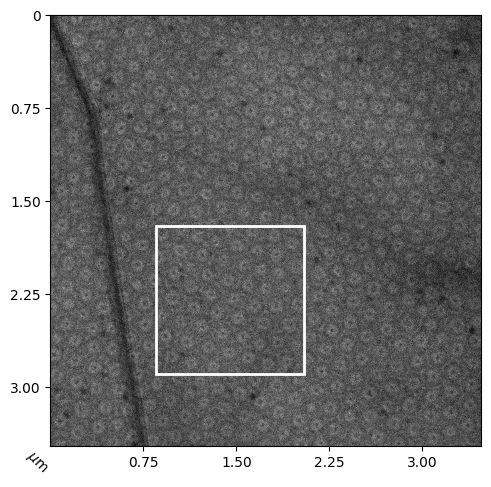

In [95]:
file_CGT = Path("./data/CGT_Tx0_Ty0_B500_df-0.7mm_T30K.dm4")
image, mdata = read_image(file_CGT)
mdata["defocus_values"] = -0.7 # from filename, not in file metadata
mdata["defocus_unit"] = "mm"

dd_exp = DefocusedDataset.load(
    images=image,
    metadata=mdata,

)
dd_exp.preprocess()
dd_exp.show_im()

dd_exp.transforms = {'rotation': 0, 'top': 1000, 'bottom': 1704, 'left': 500, 'right': 1204}
dd_exp.apply_transforms()
show_im(dd_exp._orig_images_preprocessed[0], roi=dd_exp.transforms, scale=dd_exp.scale, cbar=False)

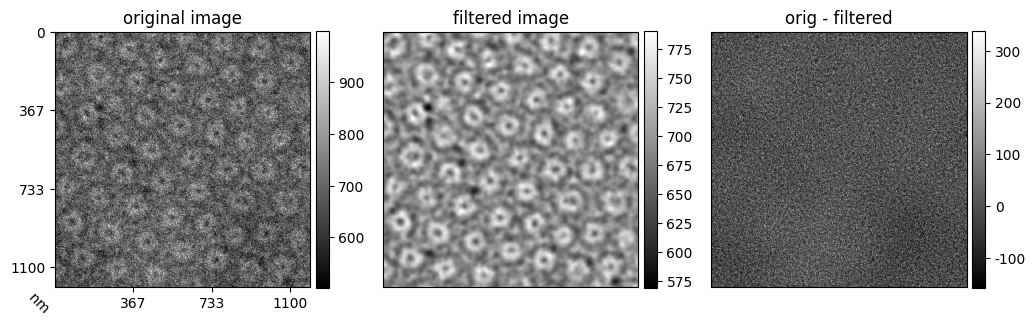

In [242]:
q_lowpass = 1 / 300  # 1/nm
q_highpass = 1 / 40  # 1/nm
dd_exp.filter(
    q_lowpass=q_lowpass, q_highpass=q_highpass, filter_type="butterworth", show=True
)


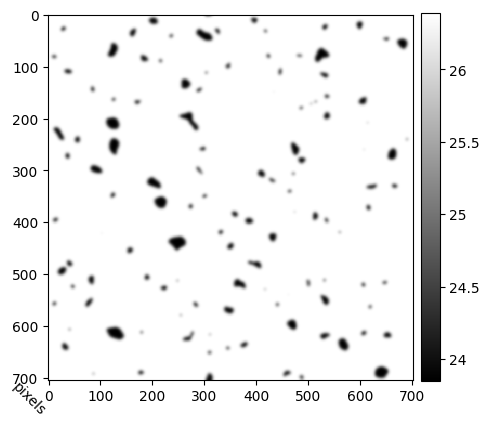

In [243]:
meanval = np.sqrt(np.mean(dd_exp.image))
minval = np.sqrt(np.min(dd_exp.image))
guess_amp = np.where(dd_exp.image>650, meanval, minval)
guess_amp = ndi.gaussian_filter(guess_amp.astype('float'), 3)
show_im(guess_amp)

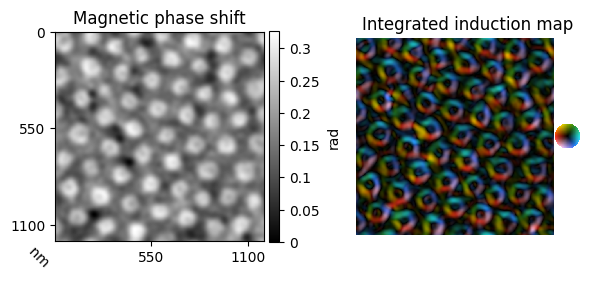

In [244]:
sitie = SITIE(dd_exp)
qc = 0.001
sitie.reconstruct(qc=qc).visualize(cbar=True)

In [245]:
LRs = {
    "phase": 2e-4, # 2e-4 for DIP, 0.2 otherwise
    "amp": 2e-4, # 2e-4 for DIP, 0.02 otherwise
    "amp_scale": 0.1, # used when not solve_amp, 0.1 best
    "amp2phi_scale": 1,
    "TV_phase_weight": 10, #
}

# sample params can/should be approximated, they are used to calculate the scaling factor
# that converts amplitude -> phase_E, but this parameter will be learned.
# here we set them to a factor of 2 greater than the "true" values to demonstrate this
sample_params = {
    "dirt_V0" : 20,
    "dirt_xip0" : 10,
}


siprad_exp = ADPhase(
    dd=dd_exp,
    device=device,
    scope=scope,
    sample_params=sample_params,
    LRs=LRs,
    scheduler_type=None,
    noise_frac=1/100,
    gaussian_sigma=3,
)

DIP_phase = DIP_NN()


Proceeding with GPU 0: NVIDIA RTX 2000 Ada Generation Laptop GPU


SITIE guess phase:


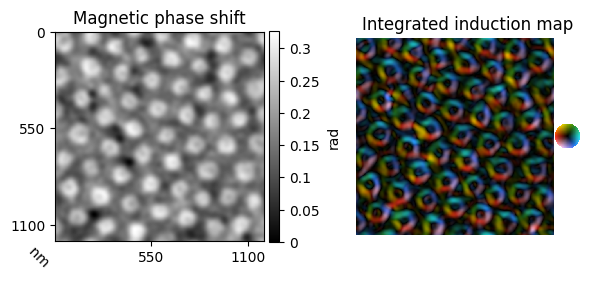

Pre-training


100%|██████████| 500/500 [00:12<00:00, 38.55it/s]


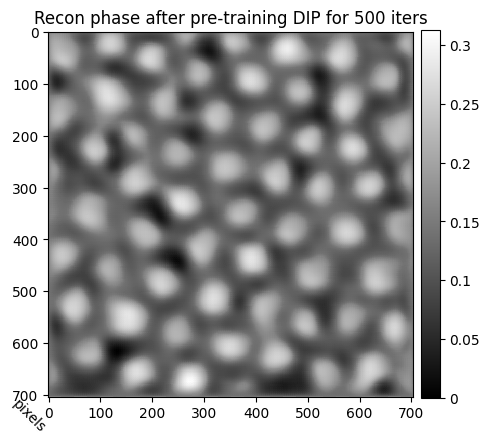

Reconstructing


 50%|████▉     | 499/1000 [00:15<00:22, 22.23it/s]

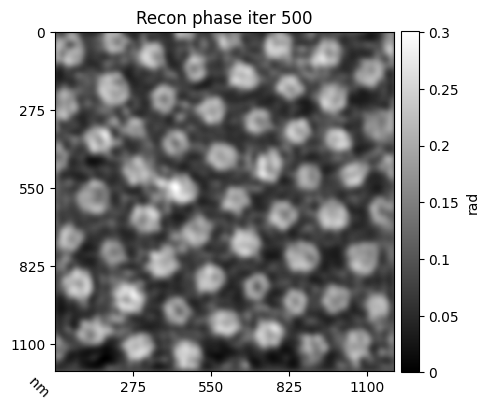

100%|█████████▉| 998/1000 [00:31<00:00, 35.16it/s]

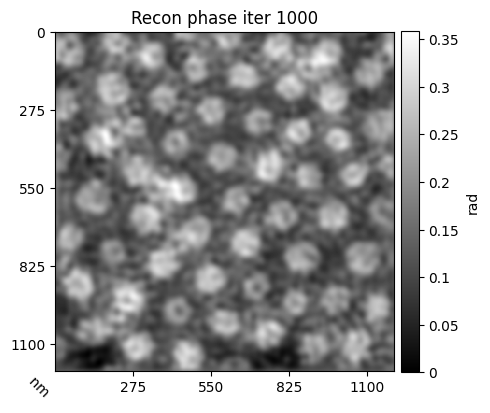

100%|██████████| 1000/1000 [00:31<00:00, 32.04it/s]


total time (h:m:s) = 0:00:45


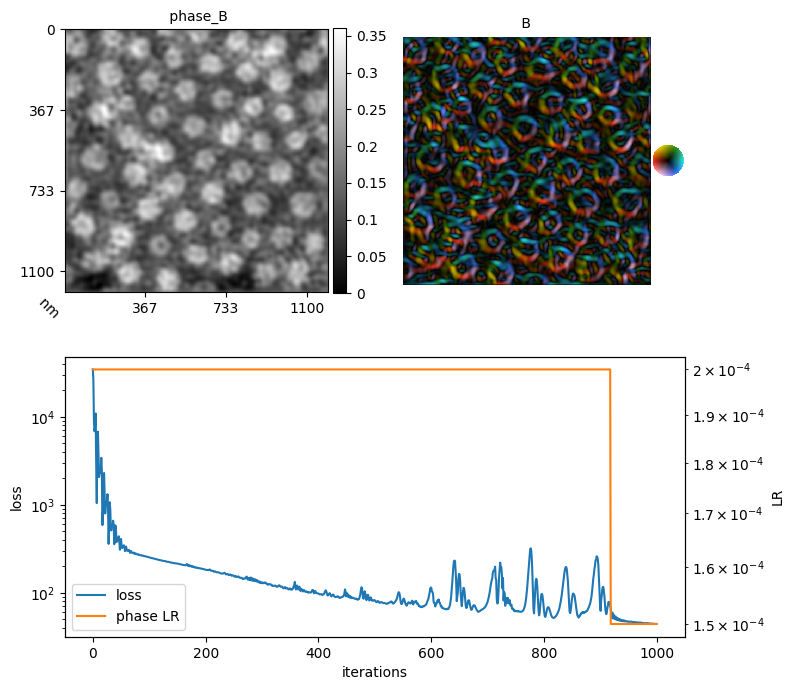

In [246]:
siprad_exp.reconstruct(
    num_iter=1000,
    model = DIP_phase,
    num_pretrain_iter=500,
    solve_amp_scale = True,
    guess_amp=guess_amp,
    reset=True, # will reset model weights
    store_iters_every=500,
    verbose = 2, # verbose = 2 to show plots
    scheduler_type="plateau",
    qc=0.001,
)

siprad_exp.visualize()

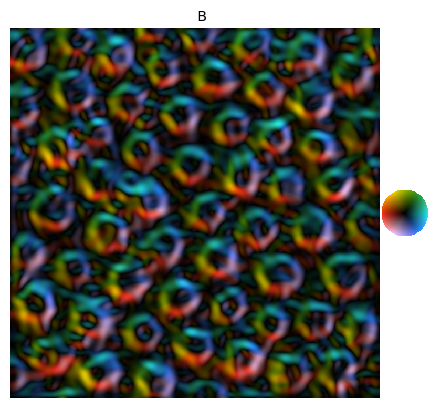

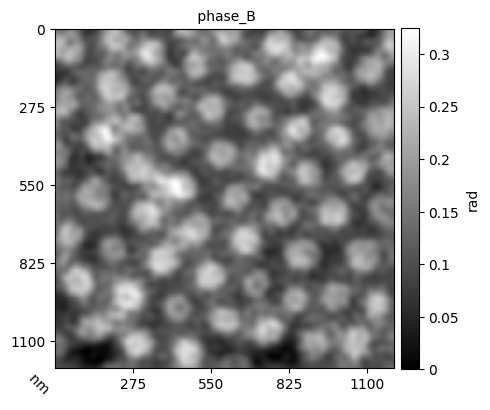

In [247]:
siprad_exp.gaussian_sigma = 6
siprad_exp.show_B()
siprad_exp.show_phase_B()

In [248]:
siprad_exp._compute_loss(return_seperate=True)

(tensor(44.2996, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.0043, device='cuda:0', grad_fn=<DivBackward0>))

In [249]:
LRs = {
    "phase": 2e-4, # 2e-4 for DIP, 0.2 otherwise
    "amp": 2e-4, # 2e-4 for DIP, 0.02 otherwise
    "amp_scale": 0.1, # used when not solve_amp, 0.1 best
    "amp2phi_scale": 1,
    "TV_phase_weight": 1e4, #
}
siprad_exp.LRs = LRs
siprad_exp._compute_loss(return_seperate=True)

(tensor(44.2996, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(4.2743, device='cuda:0', grad_fn=<DivBackward0>))

Reconstructing


 50%|████▉     | 498/1000 [00:19<00:23, 21.21it/s]

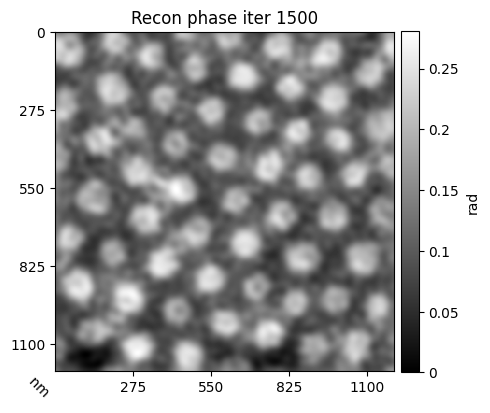

100%|█████████▉| 998/1000 [00:43<00:00, 23.57it/s]

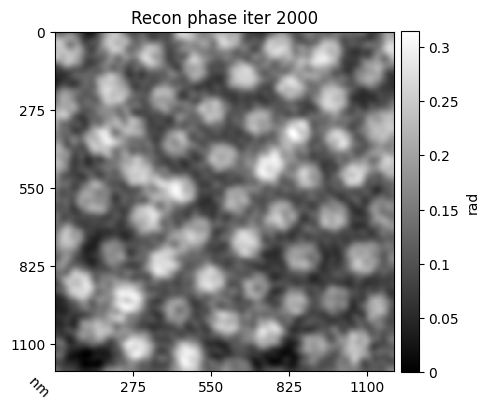

100%|██████████| 1000/1000 [00:44<00:00, 22.67it/s]


total time (h:m:s) = 0:00:44


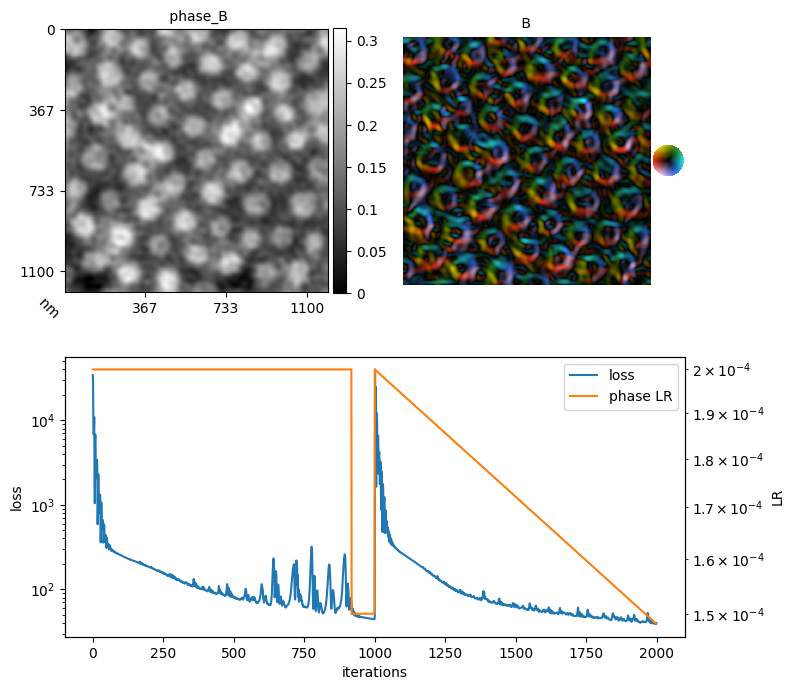

In [250]:
siprad_exp.reconstruct(
    num_iter=1000,
    model = DIP_phase,
    num_pretrain_iter=300,
    solve_amp_scale = True,
    guess_amp=guess_amp,
    reset=False, # will reset model weights
    store_iters_every=500,
    verbose = 2, # verbose = 2 to show plots
    scheduler_type="plateau",
    qc=0.001,
)

siprad_exp.visualize()

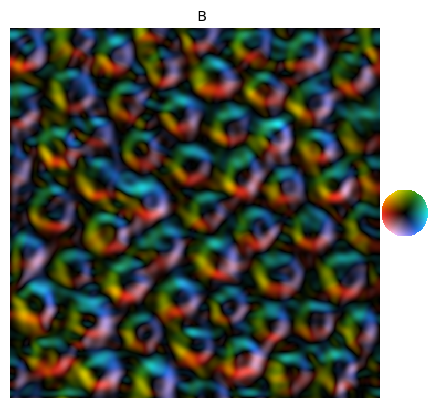

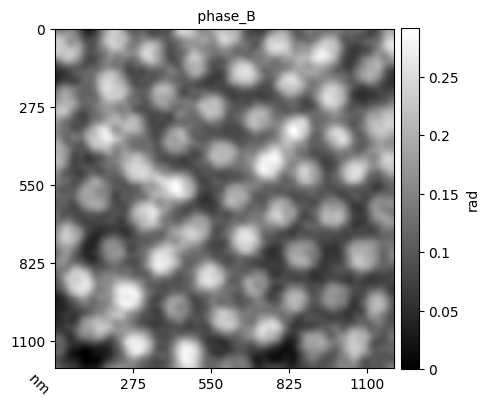

In [254]:
siprad_exp.gaussian_sigma = 8
siprad_exp.show_B()
siprad_exp.show_phase_B()

### not gonna include reconstructing amp with DIP

In [62]:
LRs = {
    "phase": 2e-4, # 2e-4 for DIP, 0.2 otherwise
    "amp": 2e-4, # 2e-4 for DIP, 0.02 otherwise
    "amp_scale": 1, # used when not solve_amp, 0.1 best
    "amp2phi_scale": 1,
    "TV_phase_weight": 0.1, #
    "TV_amp_weight": 0.1, #
}

# sample params can/should be approximated, they are used to calculate the scaling factor
# that converts amplitude -> phase_E, but this parameter will be learned.
# here we set them to a factor of 2 greater than the "true" values to demonstrate this
sample_params = {
    "dirt_V0" : 20,
    "dirt_xip0" : 10,
}


siprad_amp = ADPhase(
    dd=dirty_dd,
    device=device,
    scope=scope,
    sample_params=sample_params,
    LRs=LRs,
    scheduler_type=None,
    noise_frac=1/100,
    gaussian_sigma=1,
)

DIP_phase = DIP_NN()
DIP_amp = DIP_NN()


Proceeding with GPU 0: NVIDIA RTX 2000 Ada Generation Laptop GPU


SITIE guess phase:


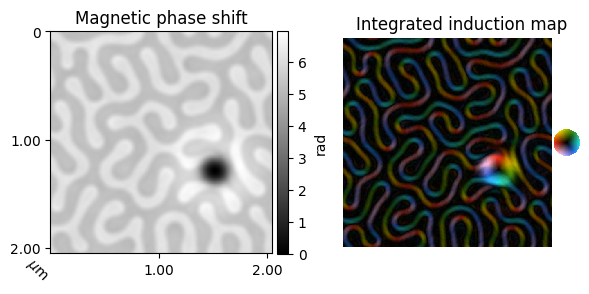

Pre-training


100%|██████████| 200/200 [00:05<00:00, 36.02it/s]


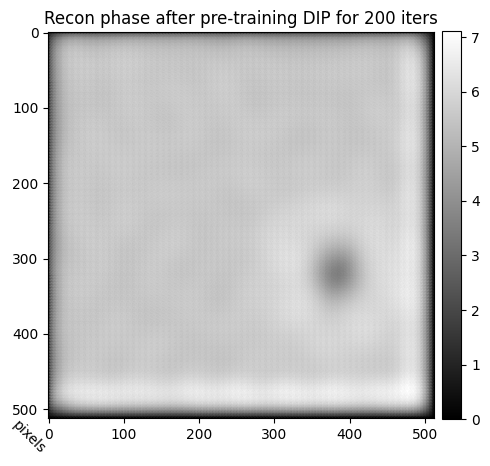

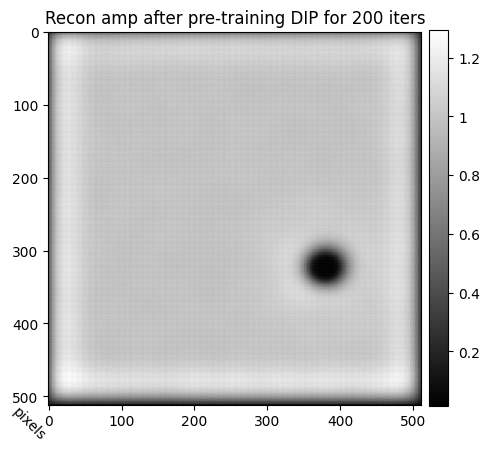

Reconstructing
Solving for amplitude


100%|██████████| 200/200 [00:08<00:00, 23.79it/s]


total time (h:m:s) = 0:00:14
SIPRAD   phase: acc -3.8% SSIM 0.267 | Bave: acc -1.4% SSIM 0.450
SITIE    phase: acc 57.8% SSIM 0.231 | Bave: acc 76.4% SSIM 0.728


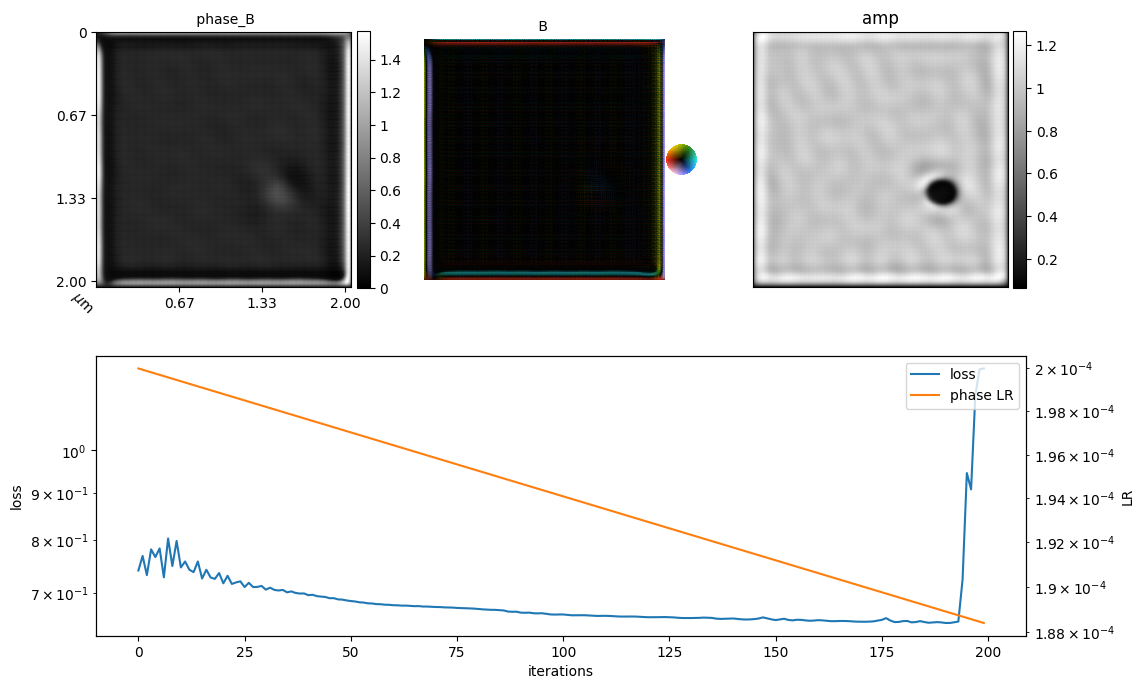

In [63]:
siprad_amp.reconstruct(
    num_iter=200,
    model = (DIP_phase, DIP_amp),
    num_pretrain_iter=200,
    solve_amp=True,
    guess_amp=guess_amp,
    solve_amp_scale=False,
    reset=True, # will reset model weights
    store_iters_every=500,
    verbose = 2, # verbose = 2 to show plots
    scheduler_type="exp",
    qc=0.001,
    guess_phase="sitie",
)

siprad_amp.visualize()

siprad_metrics = siprad_amp.calc_phase_metrics(simulator.phase_B, siprad_amp.best_phase)
sitie_metrics = siprad_amp.calc_phase_metrics(simulator.phase_B, siprad_amp.guess_phase)
print(f"{'SIPRAD':8} phase: acc {siprad_metrics['acc_phase']*100:.1f}% SSIM {siprad_metrics['SSIM_phase']:.3f} | Bave: acc {siprad_metrics['acc_Bave']*100:.1f}% SSIM {siprad_metrics['SSIM_Bave']:.3f}")
print(f"{'SITIE':8} phase: acc {sitie_metrics['acc_phase']*100:.1f}% SSIM {sitie_metrics['SSIM_phase']:.3f} | Bave: acc {sitie_metrics['acc_Bave']*100:.1f}% SSIM {sitie_metrics['SSIM_Bave']:.3f}")

In [ ]:

pdict = {}
pdict['scale'] = dd.scale
pdict['save_home'] = "./"
pdict['dataname'] = "SIPRAD_demo_CGT"
pdict['device'] = device
pdict['mode'] = "sim"

pdict["defvals"] = np.array(defvals)
pdict['noise_vals'] = noiser.__dict__

pdict['DIP'] = True # Whether or not to use a DIP
pdict['solve_amp'] = False
pdict['notes'] = ""

pdict['show'] = True

pdict['maxiter'] = 1000 # convergence speed varies, but 1000 iters should be plenty
pdict['pre-train_dip'] = 500
pdict['scheduler'] = "plateau" # none, cyclic, plateau, exp
pdict['plateau_patience'] = 50

optLR = [0.2, 0.02] # (phase LR, amp LR) if not using DIP
dipLR = [2e-4, 2e-4] # LR for DIP, (phase, amp)
tvLR = [0.005, 0] # (phase TV weight, amp TV weight) (1,0) for small, only if not using DIP
sigma = 2 # gaussian smoothing output phase
pdict['DIP_noise_frac'] = 0 if pdict['solve_amp'] else 1/30
pdict["start_mode"] = "random" if pdict['solve_amp'] else "SITIE" # random, uniform, true_phase, SITIE


plt.close('all')

### define the guess or input phase/amps
if pdict["start_mode"] == "random":
    inp_phase = np.random.rand(*inp_ims[0].shape)*2-1
elif pdict["start_mode"] == "uniform":
    inp_phase = np.zeros(inp_ims[0].shape)
elif pdict["start_mode"] == "true_phase":
    inp_phase = np.copy(true_phase)
elif pdict["start_mode"] == "SITIE":
    if pdict['solve_amp']:
        print("\n============\nStarting with SITIE for solve amp, not recommended\n===========\n")
    # inp_phase = SITIE(inp_ims[0].cpu().detach().numpy(),
    #                     dfs[0], pdict['scale'], v=0)['phase_b']
    # sitie = SITIE.from_array(
    #     image = inp_ims[0].cpu().detach().numpy(),
    #     scale = scale,
    #     defval = dfs[0],
    #     beam_energy = scope.E,
    #     simulated = True,
    # )
    sitie = SITIE(noisy_dd)
    sitie.reconstruct().visualize()
    inp_phase = sitie.phase_B.copy()
    show_im(inp_phase-inp_phase.min(), "input phase from SITIE")

guess_phase = torch.tensor(inp_phase, dtype=torch.float32, device=device,
                           requires_grad=True)
guess_amp = torch.tensor(np.ones_like(noisy_dd.images)*np.sqrt(noisy_dd.images.mean()), device=device, dtype=torch.float32, requires_grad=False)

if pdict['DIP']:
    dipP = DIP_NN().to(device)

    dipA = None
    optimizer = torch.optim.Adam([
        {'params': dipP.parameters(), 'lr':dipLR[0]},
        ])
    tvLR = [0, 0] # not strictly necessary as if pdict['DIP'] then TV loss won't be calc
    LRs = dipLR # for scheduler

else:
    dipP = None
    dipA = None
    optimizer = torch.optim.Adam([
        {'params': guess_phase, 'lr':optLR[0]}
        ])
    LRs = optLR

pdict["LRs"] = [optLR, tvLR, dipLR]
inp_ims = torch.tensor(inp_ims, device=pdict['device'])
guess_amp, guess_phase, best_amp, best_phase, losses = training_loop(inp_ims,
                                                                     guess_amp,
                                                                     guess_phase,
                                                                     TFs,
                                                                     pdict,
                                                                     dipA,
                                                                     dipP,
                                                                     print_every = 200)
losses=np.array(losses)
fig, ax = plt.subplots(ncols=2, figsize = (8,3))
ax[0].plot(losses[:,0])
ax[0].set_xlabel("iterations")
ax[0].set_ylabel("loss")
ax[1].semilogy(losses[:,0], label='losses')
ax[1].set_xlabel("iterations")
ax2 = ax[1].twinx()
ax2.plot(losses[:,1],color='orange', label='LR')
plt.legend()
minloss_iter = np.argmin(losses[:,0])
fphase = guess_phase.cpu().detach().numpy()
bphase = best_phase.cpu().detach().numpy()
fphase = ndi.gaussian_filter(fphase, sigma, mode='wrap')
bphase = ndi.gaussian_filter(bphase, sigma, mode='wrap')
gamp = guess_amp.cpu().detach().numpy()
bamp = best_amp.cpu().detach().numpy()
gamp = ndi.gaussian_filter(gamp, sigma, mode='wrap')
bamp = ndi.gaussian_filter(bamp, sigma, mode='wrap')
final_By, final_Bx = induction_from_phase(fphase, pdict['scale'])
best_By, best_Bx = induction_from_phase(bphase, pdict['scale'])

show_im(fphase, "final phase", cbar_title="rad")
true_phase = simulator.phase_B
a = true_phase.shape[0]//16
pdict['acc_crop'] = a
get_all_accs(fphase[a:-a,a:-a], bphase[a:-a,a:-a], true_phase[a:-a,a:-a], pdict)

print(f"\nGuess phi accuracy {pdict['guess_phi_acc']*100:.3f}% best accuracy: {pdict['best_phi_acc']*100:.3f}%")
print(f"Guess phi SS {pdict['guess_phi_SS']*100:.3f} best phi SS: {pdict['best_phi_SS']*100:.3f}")

print(f"Guess B accuracy (Bx, By, Bmag) ({pdict['guess_Bx_acc']*100:.3f}, {pdict['guess_By_acc']*100:.3f}, {pdict['guess_Bmag_acc']*100:.3f})%  best accuracy: ({pdict['best_Bx_acc']*100:.3f}, {pdict['best_By_acc']*100:.3f}, {pdict['best_Bmag_acc']*100:.3f})%")
print(f"Guess B SS (Bx, By, Bmag) ({pdict['guess_Bx_SS']*100:.3f}, {pdict['guess_By_SS']*100:.3f}, {pdict['guess_Bmag_SS']*100:.3f})  best B SS: ({pdict['best_Bx_SS']*100:.3f}, {pdict['best_By_SS']*100:.3f}, {pdict['best_Bmag_SS']*100:.3f})\n")

show_im(fphase, title="Reconstructed phase", cbar_title="rad")
show_2D(final_Bx, final_By, a=0, cmap='hsv', title="Reconstructed integrated induction")

In [ ]:
show_im(simulator.phase_B)
show_im(fphase)
show_im(sitie.phase_B)

# Old

In [ ]:
phase_f = Path("./data/CGT_phaseshift.tif")
true_phase, mdata = read_image(phase_f)
scale = mdata["scale"]
show_im(true_phase, title="True phase", scale=scale, cmap="viridis", cbar_title="rad")


pdict = {}
pdict['scale'] = scale
pdict['save_home'] = "./"
pdict['dataname'] = "SIPRAD_demo_CGT"
pdict['device'] = device
pdict['mode'] = "sim"

In [ ]:
true_By, true_Bx = induction_from_phase(true_phase, scale)
show_2D(true_Bx, true_By, a=0, cmap='hsv', title="True integrated induction")

In [ ]:
true_amp = np.ones_like(true_phase)

dfs = [-1_000_000] # -1mm
beam_energy = 200e3
scope = Microscope(E=beam_energy, Cs = 200.0e3, theta_c = 0.01e-3, def_spr = 80.0)
GNoise = 0 # % Gaussian noise

noiser = image_noiser(
    gauss = GNoise, # percent noise, 0+
    poisson = 0.6, # 0+ , ~0.4
    salt_and_pepper = 0, # 0+, ~10
    blur = 0, # sigma, 0+, ~0.5
    contrast = None, # 1-, 1+
    bkg = 0, # 0+, ~1
    seed = 42,
)

pdict["defvals"] = np.array(dfs)
pdict['noise_vals'] = noiser.__dict__
print(f"defvals (mm): {pdict['defvals']/1e6}")

TFs = torch.tensor(np.array([get_TF(scope, true_phase.shape, defval, pdict["scale"]) for defval in pdict["defvals"]]),
                         device=device)

inp_ims_nonoise = sim_images_torch(torch.tensor(true_phase, device=device),
                     TFs,
                     torch.tensor(true_amp, device=device),
                     )

inp_ims = noiser.run(inp_ims_nonoise).float()
show_im(inp_ims[0].cpu().detach().numpy(), scale=pdict['scale'], title=f"defocus: {pdict['defvals'][0]/1e6} mm | G noise = {noiser.gauss}%")

In [ ]:
pdict['DIP'] = True # Whether or not to use a DIP
pdict['solve_amp'] = False
pdict['notes'] = ""

pdict['show'] = True

pdict['maxiter'] = 1000 # convergence speed varies, but 1000 iters should be plenty
pdict['pre-train_dip'] = 500
pdict['scheduler'] = "plateau" # none, cyclic, plateau, exp
pdict['plateau_patience'] = 50

optLR = [0.2, 0.02] # (phase LR, amp LR) if not using DIP
dipLR = [2e-4, 2e-4] # LR for DIP, (phase, amp)
tvLR = [0.005, 0] # (phase TV weight, amp TV weight) (1,0) for small, only if not using DIP
sigma = 2 # gaussian smoothing output phase
pdict['DIP_noise_frac'] = 0 if pdict['solve_amp'] else 1/30
pdict["start_mode"] = "random" if pdict['solve_amp'] else "SITIE" # random, uniform, true_phase, SITIE


plt.close('all')

### define the guess or input phase/amps
if pdict["start_mode"] == "random":
    inp_phase = np.random.rand(*inp_ims[0].shape)*2-1
elif pdict["start_mode"] == "uniform":
    inp_phase = np.zeros(inp_ims[0].shape)
elif pdict["start_mode"] == "true_phase":
    inp_phase = np.copy(true_phase)
elif pdict["start_mode"] == "SITIE":
    if pdict['solve_amp']:
        print("\n============\nStarting with SITIE for solve amp, not recommended\n===========\n")
    # inp_phase = SITIE(inp_ims[0].cpu().detach().numpy(),
    #                     dfs[0], pdict['scale'], v=0)['phase_b']
    sitie = SITIE.from_array(
        image = inp_ims[0].cpu().detach().numpy(),
        scale = scale,
        defval = dfs[0],
        beam_energy = scope.E,
        simulated = True,
    )
    sitie.reconstruct()
    inp_phase = sitie.phase_B.copy()
    show_im(inp_phase-inp_phase.min(), "input phase from SITIE")

guess_phase = torch.tensor(inp_phase, dtype=torch.float32, device=device,
                           requires_grad=True)
guess_amp = torch.tensor(torch.ones(inp_phase.shape, device=device)*torch.sqrt(inp_ims.mean()), device=device, dtype=torch.float32, requires_grad=False)

if pdict['DIP']:
    dipP = DIP_NN().to(device)

    dipA = None
    optimizer = torch.optim.Adam([
        {'params': dipP.parameters(), 'lr':dipLR[0]},
        ])
    tvLR = [0, 0] # not strictly necessary as if pdict['DIP'] then TV loss won't be calc
    LRs = dipLR # for scheduler

else:
    dipP = None
    dipA = None
    optimizer = torch.optim.Adam([
        {'params': guess_phase, 'lr':optLR[0]}
        ])
    LRs = optLR

pdict["LRs"] = [optLR, tvLR, dipLR]
guess_amp, guess_phase, best_amp, best_phase, losses = training_loop(inp_ims,
                                                                     guess_amp,
                                                                     guess_phase,
                                                                     TFs,
                                                                     pdict,
                                                                     dipA,
                                                                     dipP,
                                                                     print_every = 200)
losses=np.array(losses)
fig, ax = plt.subplots(ncols=2, figsize = (8,3))
ax[0].plot(losses[:,0])
ax[0].set_xlabel("iterations")
ax[0].set_ylabel("loss")
ax[1].semilogy(losses[:,0], label='losses')
ax[1].set_xlabel("iterations")
ax2 = ax[1].twinx()
ax2.plot(losses[:,1],color='orange', label='LR')
plt.legend()
minloss_iter = np.argmin(losses[:,0])
fphase = guess_phase.cpu().detach().numpy()
bphase = best_phase.cpu().detach().numpy()
fphase = ndi.gaussian_filter(fphase, sigma, mode='wrap')
bphase = ndi.gaussian_filter(bphase, sigma, mode='wrap')
gamp = guess_amp.cpu().detach().numpy()
bamp = best_amp.cpu().detach().numpy()
gamp = ndi.gaussian_filter(gamp, sigma, mode='wrap')
bamp = ndi.gaussian_filter(bamp, sigma, mode='wrap')
final_By, final_Bx = induction_from_phase(fphase, pdict['scale'])
best_By, best_Bx = induction_from_phase(bphase, pdict['scale'])

show_im(fphase, "final phase", cbar_title="rad")
a = true_phase.shape[0]//16
pdict['acc_crop'] = a
get_all_accs(fphase[a:-a,a:-a], bphase[a:-a,a:-a], true_phase[a:-a,a:-a], pdict)

print(f"\nGuess phi accuracy {pdict['guess_phi_acc']*100:.3f}% best accuracy: {pdict['best_phi_acc']*100:.3f}%")
print(f"Guess phi SS {pdict['guess_phi_SS']*100:.3f} best phi SS: {pdict['best_phi_SS']*100:.3f}")

print(f"Guess B accuracy (Bx, By, Bmag) ({pdict['guess_Bx_acc']*100:.3f}, {pdict['guess_By_acc']*100:.3f}, {pdict['guess_Bmag_acc']*100:.3f})%  best accuracy: ({pdict['best_Bx_acc']*100:.3f}, {pdict['best_By_acc']*100:.3f}, {pdict['best_Bmag_acc']*100:.3f})%")
print(f"Guess B SS (Bx, By, Bmag) ({pdict['guess_Bx_SS']*100:.3f}, {pdict['guess_By_SS']*100:.3f}, {pdict['guess_Bmag_SS']*100:.3f})  best B SS: ({pdict['best_Bx_SS']*100:.3f}, {pdict['best_By_SS']*100:.3f}, {pdict['best_Bmag_SS']*100:.3f})\n")

show_im(fphase, title="Reconstructed phase", cbar_title="rad")
show_2D(final_Bx, final_By, a=0, cmap='hsv', title="Reconstructed integrated induction")

In [ ]:
show_im(simulator.phase_B)

In [ ]:
show_im(fphase-fphase.min())

In [ ]:
show_im(sitie.phase_B)